+--------+---------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------+-------------+----------+--------------------+-----------------+
|match_no|     city|date_of_match|               venue|           Home_team|           Away_team|         toss_winner|              winner|man_of_the_match| result|result_margin|eliminator|             umpire1|          umpire2|
+--------+---------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------+-------------+----------+--------------------+-----------------+
|       1|Ahmedabad|   2023-03-31|Narendra Modi Sta...|      Gujarat Titans| Chennai Super Kings|      Gujarat Titans|      Gujarat Titans|     Rashid Khan|Wickets|            5|         N|         Nitin Menon|    Saiyed Khalid|
|       2|   Mohali|   2023-04-01|Punjab Cricket As...|        Punjab Kings|Kolkata 

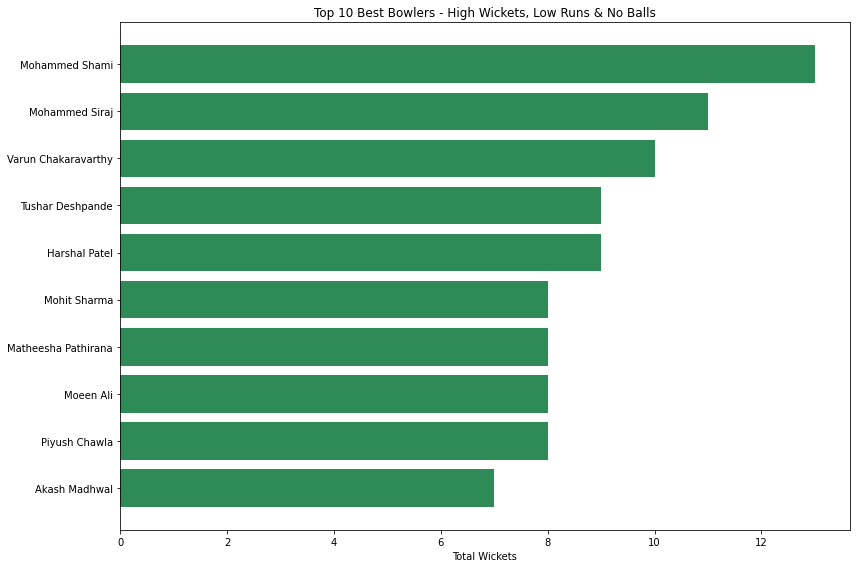

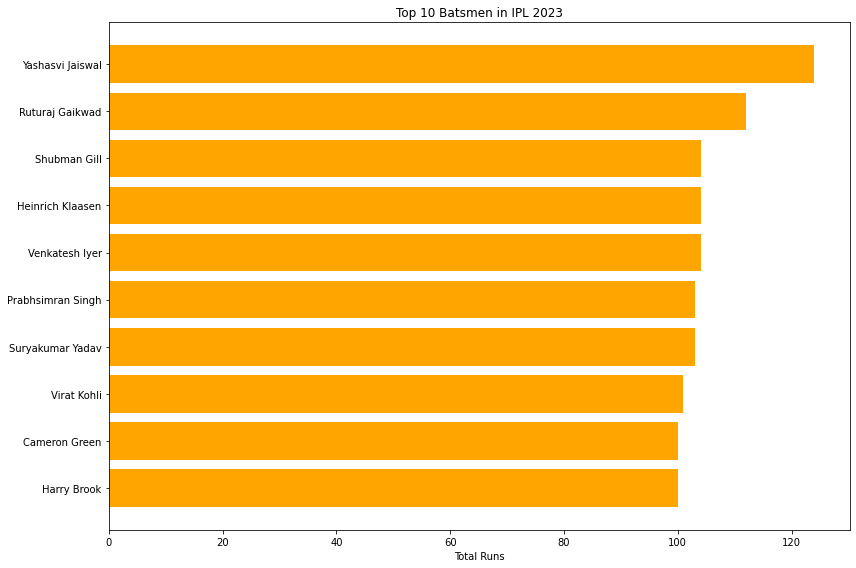

In [0]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DecimalType, DateType
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("IPL Analysis").getOrCreate()

IPL2023_Matches_df = spark.read.format("csv").option("header","true").option("InferSchema","true").load("/FileStore/tables/IPL2023_Matches.csv")

IPL2023_Matches_df.show(5)
IPL2023_Batsman_df = spark.read.format("csv").option("header","true").option("InferSchema","true").load("/FileStore/tables/IPL2023_Batsman.csv")

IPL2023_Batsman_df.show(5)

IPL2023_Bowler_df = spark.read.format("csv").option("header", "true").option("InferSchema", "true").load("/FileStore/tables/IPL2023_Bowler.csv")

IPL2023_Bowler_df.show(5)
IPL2023_MatchScoreboard_df = spark.read.format("csv").option("header","true").option("InferSchema","true").load("/FileStore/tables/IPL2023_Match_Scoreboard.csv")

IPL2023_MatchScoreboard_df.show(5)



                                                                                                                    

# Aggregation: calculate total runs by each match and team

total_avg_runs_by_team = IPL2023_Batsman_df.groupby("match_no", "team").agg(sum("Run").alias("total_runs"),avg("Run").alias("avg_runs")
)



# Team with most 6s
team_most_sixes = IPL2023_Batsman_df.groupBy("team").agg(sum("6s").alias("total_sixes")).orderBy("total_sixes", ascending=False)
most_six_team = team_most_sixes.collect()[0]["team"]
IPL2023_Batsman_df = IPL2023_Batsman_df.withColumn("team_most_sixes", lit(most_six_team))

# Team with most 4s
team_most_fours = IPL2023_Batsman_df.groupBy("team").agg(sum("4s").alias("total_fours")).orderBy("total_fours", ascending=False)

most_fours_team = team_most_fours.collect()[0]["team"]
IPL2023_Batsman_df = IPL2023_Batsman_df.withColumn("team_most_fours", lit(most_fours_team))


# Batsman with highest total runs
top_batsman = IPL2023_Batsman_df.groupBy("Batsman").agg(sum("Run").alias("total_runs")).orderBy("total_runs", ascending=False)
top_batsman_name = top_batsman.collect()[0]["Batsman"]
IPL2023_Batsman_df = IPL2023_Batsman_df.withColumn("top_batsman", lit(top_batsman_name))



# Rank the batsman according to the highest runs by each teams
windowSpec = Window.partitionBy("team").orderBy(col("Run").desc())
IPL2023_Batsman_df = IPL2023_Batsman_df.withColumn("rank", rank().over(windowSpec))
IPL2023_Batsman_df.show(5)









#find out which bowler gave more no_ball

from pyspark.sql.functions import sum, countDistinct, col, lower, regexp_replace
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, desc, asc

# Step 1: Backup original dataframe
original_bowler_df = IPL2023_Bowler_df

# Step 2: Compute total no balls per bowler
most_no_ball = original_bowler_df.groupBy("Bowler") \
    .agg(sum("No_ball").alias("total_no_balls")) \
    .orderBy(col("total_no_balls").desc())

# Step 3: Compute main bowler stats
from pyspark.sql.functions import collect_set

bowler_stats_df = original_bowler_df.groupBy("Bowler", "team") \
    .agg(
        countDistinct("match_no").alias("matches_played"),
        sum("wicket").alias("total_wickets"),
        sum("run").alias("total_runs"),
        collect_set("match_no").alias("match_nos")
    )

# Step 4: Add ranking
windowSpec = Window.orderBy(
    desc("total_wickets"),
    asc("total_runs"),
    desc("matches_played")
)

bowler_stats_df = bowler_stats_df.withColumn("rank", dense_rank().over(windowSpec))

# Step 5: Join total_no_balls into bowler_stats_df
combined_df = bowler_stats_df.join(most_no_ball, on="Bowler", how="left")

# Step 6: Normalize bowler names (after all joins)
combined_df = combined_df.withColumn("Bowler", lower(regexp_replace("Bowler", "[^a-zA-Z0-9 ]", "")))

# Final output
combined_df.show(5)

#date,year,month from the date_of_match

IPL2023_Matches_df = IPL2023_Matches_df.withColumn("day",dayofmonth("date_of_match"))
IPL2023_Matches_df = IPL2023_Matches_df.withColumn("year",year("date_of_match"))
IPL2023_Matches_df = IPL2023_Matches_df.withColumn("month",month("date_of_match"))
# High margin winner: categorize them into high,medium,low 

IPL2023_Matches_df = IPL2023_Matches_df.withColumn(
    "high_win_margin",
    when(col("result_margin") >= 100, "high")
    .when((col("result_margin") >= 50) & (col("result_margin") < 100), "medium")
    .otherwise("low")
)
# Handle missing values in city with a default 'unknown'
IPL2023_Matches_df = IPL2023_Matches_df.na.fill({"city": "unknown"})
# Analyzing the toss impact : who wins the toss and match

IPL2023_Matches_df = IPL2023_Matches_df.withColumn("toss_match_winner",when(col("toss_winner") == col("winner"), "yes").otherwise("no"))

IPL2023_Matches_df.show(5)





IPL2023_Batsman_df.createOrReplaceTempView("Batter")
IPL2023_Bowler_df.createOrReplaceTempView("Bowler")
IPL2023_Matches_df.createOrReplaceTempView("Matches")







best_batter = spark.sql("""
    SELECT 
        b.Batsman,
        b.team AS batting_team,
        SUM(b.Run) AS total_runs,
        m.venue,
        m.date_of_match,
        CASE 
            WHEN b.team = m.Home_team THEN m.Away_team
            ELSE m.Home_team
        END AS opponent_team,
        m.winner,
        COUNT(DISTINCT b.match_no) AS matches_played
    FROM 
        batter b
    JOIN 
        matches m ON b.match_no = m.match_no
    GROUP BY 
        b.Batsman, b.team, m.venue, m.date_of_match, 
        CASE 
            WHEN b.team = m.Home_team THEN m.Away_team
            ELSE m.Home_team
        END,
        m.winner
    ORDER BY 
        total_runs DESC
    LIMIT(12)
""")
best_batter.show()






best_bowler = spark.sql("""
SELECT 
    b.Bowler,
    b.team,
    COUNT(DISTINCT b.match_no) AS matches_played,
    SUM(b.wicket) AS total_wickets,
    SUM(b.run) AS total_runs_given,
    SUM(b.No_ball) AS total_no_balls,
    m.city,
    m.venue,
    DENSE_RANK() OVER (
        ORDER BY 
            SUM(b.wicket) DESC,
            SUM(b.run) ASC,
            SUM(b.No_ball) ASC
    ) AS performance_rank
FROM 
    bowler b
JOIN 
    matches m 
ON 
    b.match_no = m.match_no
GROUP BY 
    b.Bowler, b.team, m.city, m.venue
""")
best_bowler.show()



import matplotlib.pyplot as plt

# Convert Spark sql to Pandas
best_bowlers_pd = best_bowler.toPandas()

# Sort by rank (lower rank = better performance)
top_bowlers = best_bowlers_pd.nsmallest(10, 'performance_rank')

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_bowlers['Bowler'], top_bowlers['total_wickets'], color='seagreen')
plt.xlabel('Total Wickets')
plt.title('Top 10 Best Bowlers - High Wickets, Low Runs & No Balls')
plt.gca().invert_yaxis()  # So the best bowler (rank 1) appears at the top
plt.tight_layout()
plt.show()











import matplotlib.pyplot as plt
top_batsmen_pd = best_batter.toPandas()

plt.figure(figsize=(12, 8))
plt.barh(top_batsmen_pd['Batsman'], top_batsmen_pd['total_runs'], color='orange')
plt.xlabel('Total Runs')
plt.title('Top 10 Batsmen in IPL 2023')
plt.gca().invert_yaxis()  # Highest scorer on top
plt.tight_layout()
plt.show()






